# Import

In [1]:
import os
import numpy as np

from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import lightkurve as lk
from astroquery.simbad import Simbad
import pandas as pd 
from numpy import genfromtxt
from sklearn.preprocessing import normalize

# #tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



## Check GPU

In [2]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Data

In [3]:
pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v3/0.csv',delimiter=',').to_numpy().shape

(122, 475)

In [53]:
all_data = np.empty((1,475))
for i in range(1609):
  try:
    all_data = np.concatenate((all_data,pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v3/'+str(i)+'.csv',delimiter=',').to_numpy()), axis=0)
  except:
    continue
all_data = all_data[1:].T[1:].T
print(all_data.shape)
# pd.read_csv('/content/drive/MyDrive/Research - Yihong Song and Rohit Prasanna/Yihong/Data_v2/0.csv',delimiter=',').to_numpy

(77197, 474)


In [54]:
print(all_data)
print(all_data.T[1])

[[7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 5.85052317e+00
  9.69580351e+00 7.87920306e+00]
 [7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 4.51275398e+00
  4.17921295e+00 5.35710573e+00]
 [7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 2.39391900e+00
  3.23821209e+00 3.50633041e+00]
 ...
 [1.24553570e+07 4.63300000e+03 2.35500000e+00 ... 7.22105298e+00
  6.25722946e+00 6.97677380e+00]
 [1.24553570e+07 4.63300000e+03 2.35500000e+00 ... 5.24570461e+00
  6.56183340e+00 5.67633786e+00]
 [1.24553570e+07 4.63300000e+03 2.35500000e+00 ... 5.01127168e+00
  5.92280860e+00 4.84215917e+00]]
[4751. 4751. 4751. ... 4633. 4633. 4633.]


In [55]:
def isolate_observations(data):
    kic = 0
    res = np.empty((1,474))
    for i in range(len(data)):
        if(data[i][0]!=kic):
            kic = data[i][0]
            res = np.vstack((res,data[i]))
    return res

# iso_data = isolate_observations(all_data).T[:10].T
# print(iso_data)

In [56]:
def extract_xy(all_data):
    all_x = all_data.T[3:231].T
    all_y = all_data.T[1:3].T
    print(all_x.shape,all_y.shape)
    teff_y = all_y.T[0].T
    print(teff_y.shape)
    print(teff_y)
    print(all_x[1])
    return all_x,teff_y

all_x,teff_y = extract_xy(all_data)

(77197, 228) (77197, 2)
(77197,)
[4751. 4751. 4751. ... 4633. 4633. 4633.]
[1.         4.20230387 5.08429584 2.8705257  3.03384979 3.09656549
 3.75869284 3.02637558 3.31568472 3.41449566 3.89064309 4.46707678
 2.84617214 4.34024907 4.44872399 5.03072533 2.98603345 3.9704044
 4.04709734 2.80572554 2.4993625  2.28989815 2.79916182 3.17560122
 2.09595172 1.70385558 2.22020202 1.28954937 1.33034144 1.36817343
 1.44803374 1.22482013 1.17279956 1.15741269 1.02777875 0.83268147
 1.07621558 1.01634899 1.04705778 0.75180739 0.98345645 0.52860498
 0.64266898 0.91150894 0.64917226 0.72432438 0.53779949 0.42462443
 0.3537338  0.4926552  0.78995761 0.55776332 0.57220055 0.57275563
 0.49731549 0.43799971 0.4458369  0.45464592 0.62300697 0.3417187
 0.4578065  0.49357301 0.48549321 0.46430902 0.59852467 0.39175011
 0.46451555 0.35469993 0.4856069  0.31489359 0.29580494 0.37052073
 0.34718435 0.3317955  0.37470149 0.33784652 0.34154617 0.28003836
 0.34905947 0.35260452 0.31909339 0.28457844 0.3655531  

In [57]:
def normalize_with_moments(X_train, axes=0, epsilon=1e-8,keep_dims=True):
    x = tf.convert_to_tensor(X_train)
    mean, variance = tf.nn.moments(x, axes=axes)
    x_normed = (x - mean) / tf.sqrt(variance + epsilon) # epsilon to avoid dividing by zero
    return x_normed

def normalize_x(x):
    x = x.T
    for i in range(len(x)):
        x[i] = x[i] / np.linalg.norm(x[i])
    return x.T

In [58]:
# teff_y = normalize_with_moments(teff_y).numpy()
# all_x = normalize_x(all_x)
# print(teff_y)
# print(all_x)

In [80]:
print(all_x[1])

[1.         4.20230387 5.08429584 2.8705257  3.03384979 3.09656549
 3.75869284 3.02637558 3.31568472 3.41449566 3.89064309 4.46707678
 2.84617214 4.34024907 4.44872399 5.03072533 2.98603345 3.9704044
 4.04709734 2.80572554 2.4993625  2.28989815 2.79916182 3.17560122
 2.09595172 1.70385558 2.22020202 1.28954937 1.33034144 1.36817343
 1.44803374 1.22482013 1.17279956 1.15741269 1.02777875 0.83268147
 1.07621558 1.01634899 1.04705778 0.75180739 0.98345645 0.52860498
 0.64266898 0.91150894 0.64917226 0.72432438 0.53779949 0.42462443
 0.3537338  0.4926552  0.78995761 0.55776332 0.57220055 0.57275563
 0.49731549 0.43799971 0.4458369  0.45464592 0.62300697 0.3417187
 0.4578065  0.49357301 0.48549321 0.46430902 0.59852467 0.39175011
 0.46451555 0.35469993 0.4856069  0.31489359 0.29580494 0.37052073
 0.34718435 0.3317955  0.37470149 0.33784652 0.34154617 0.28003836
 0.34905947 0.35260452 0.31909339 0.28457844 0.3655531  0.28609421
 0.27287525 0.32178996 0.29187161 0.32573694 0.31521757 0.296023

# Machine Learning

In [81]:
train_x,test_x,train_y,test_y=train_test_split(all_x, teff_y, test_size=0.20, random_state=42)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
train_x = np.asarray(train_x).astype('float32')
test_x = np.asarray(test_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(61757, 228) (15440, 228) (61757,) (15440,)
(61757, 228) (15440, 228) (61757,) (15440,)


In [82]:
tf.test.gpu_device_name() # No GPU Sad :v
# tf.config.optimizer.set_jit(True)
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()
model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
#model.add(layers.LSTM(128,dr
# opout=0.2,recurrent_dropout=0.2,input_dim=(train_x.shape[2])))
#model.add(layers.Conv1D(1024,1,activation='relu',input_shape=(train_x.shape)))
#model.add(layers.Conv1D(256,1,activation='relu'))
model.add(layers.Dense(2048, activation="relu", input_shape=((228,))))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(4, activation="relu"))
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              468992    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1

2021-12-15 19:06:27.879101: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-15 19:06:27.879123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [83]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
# monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
#         patience=10, verbose=1, mode='auto',
#         restore_best_weights=True)

# def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('loss') <= 15000):
#         print("\n\n\nReached 0.05 loss value so cancelling training!\n\n\n")
#         model.stop_training = True


# trainingStopCallback = on_epoch_end()


In [84]:
# history = model.fit(train_x, train_y, epochs=1000,validation_data=(test_x, test_y),callbacks=[monitor], verbose=2)
history = model.fit(train_x, train_y, epochs=150,validation_data=(test_x, test_y), verbose=2)

Epoch 1/150


2021-12-15 19:06:30.243080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-15 19:06:48.286820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1930/1930 - 20s - loss: 1005776.9375 - accuracy: 0.0000e+00 - val_loss: 1217053.2500 - val_accuracy: 0.0000e+00
Epoch 2/150
1930/1930 - 20s - loss: 112416.1875 - accuracy: 0.0000e+00 - val_loss: 39626.2891 - val_accuracy: 0.0000e+00
Epoch 3/150
1930/1930 - 20s - loss: 96242.3438 - accuracy: 0.0000e+00 - val_loss: 107534.1406 - val_accuracy: 0.0000e+00
Epoch 4/150
1930/1930 - 20s - loss: 77703.4375 - accuracy: 0.0000e+00 - val_loss: 46323.4414 - val_accuracy: 0.0000e+00
Epoch 5/150
1930/1930 - 23s - loss: 79570.0312 - accuracy: 0.0000e+00 - val_loss: 37518.5977 - val_accuracy: 0.0000e+00
Epoch 6/150
1930/1930 - 23s - loss: 70707.8984 - accuracy: 0.0000e+00 - val_loss: 69824.5703 - val_accuracy: 0.0000e+00
Epoch 7/150
1930/1930 - 23s - loss: 67392.6172 - accuracy: 0.0000e+00 - val_loss: 46863.8555 - val_accuracy: 0.0000e+00
Epoch 8/150
1930/1930 - 23s - loss: 64132.4688 - accuracy: 0.0000e+00 - val_loss: 33063.4219 - val_accuracy: 0.0000e+00
Epoch 9/150
1930/1930 - 23s - loss: 60788.7383

In [85]:
model.save('/Users/michaelsong/Documents/GitHub/starzam/Models/m4.4')

INFO:tensorflow:Assets written to: /Users/michaelsong/Documents/GitHub/starzam/Models/m4.4/assets


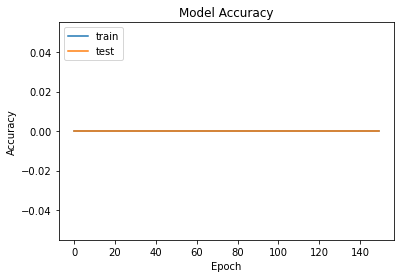

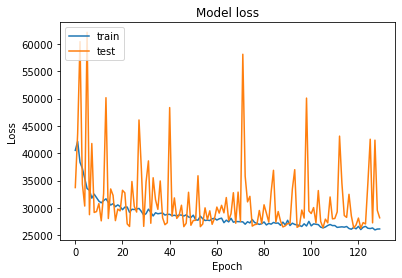

In [90]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/4.4_training.png')
plt.show()

In [91]:
pred_test_y = model.predict(test_x).reshape(-1)
pred_train_y = model.predict(train_x).reshape(-1)
print(pred_test_y.shape,pred_train_y.shape)
print(pred_train_y)
print(train_y)

(15440,) (61757,)
[5009.5005 4800.6577 4958.305  ... 4897.671  5005.0977 4645.8706]
[5333. 4781. 4985. ... 4958. 5016. 4755.]


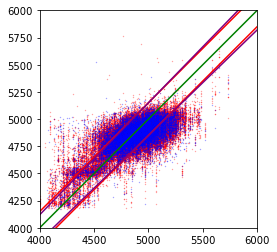

In [92]:
plt.scatter(train_y,pred_train_y, c='red', alpha=0.5,s=0.1)

plt.scatter(test_y,pred_test_y, c='blue', alpha=0.5,s=0.1)

linex = np.linspace(4000, 6000)
liney = linex
lineytop = linex+150
lineybot = linex-150
lineytop2 = linex*1.03
lineybot2 = linex*0.97
# Create the plot
plt.plot(linex, liney,c="green")
plt.plot(linex, lineytop,c="red")
plt.plot(linex, lineybot,c="red")
plt.plot(linex, lineytop2,c="purple")
plt.plot(linex, lineybot2,c="purple")


plt.xlim(4000, 6000)
plt.ylim(4000, 6000)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/4.4.png')
plt.show()


In [95]:
def normalize1D(data):
    return np.divide(np.nan_to_num(data,np.nanmean(data)),np.nanmax(data))

In [96]:
mse = np.sqrt(mean_squared_error(normalize1D(test_y),normalize1D(pred_test_y)))
mae = mean_absolute_error(normalize1D(test_y),normalize1D(pred_test_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.09713562 0.09341578


In [97]:
mse = np.sqrt(mean_squared_error(normalize1D(train_y),normalize1D(pred_train_y)))
mae = mean_absolute_error(normalize1D(train_y),normalize1D(pred_train_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.06261332 0.05774129


# Testing

In [39]:
float(model.predict(all_data[i][3:121].reshape(-1,118)))

4707.60693359375

In [50]:
def testpred_avg(all_data):
    all_y = []
    pred_all_y = []
    kic = all_data[0][0]
    kic_y = []
    for i in range(len(all_data[:10000])):
        kic_y.append(float(model.predict(all_data[i][3:121].reshape(-1,118))))
        if(all_data[i][0]!=kic):
            kic = all_data[i][0]
            all_y.append(all_data[i][1])
            pred_all_y.append(sum(kic_y)/len(kic_y))
            kic_y = []

    return all_y,pred_all_y
all_y,pred_all_y = testpred_avg(all_data)

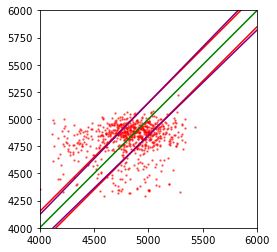

In [51]:
plt.scatter(all_y,pred_all_y, c='red', alpha=0.5,s=2)

linex = np.linspace(4000, 6000)
liney = linex
lineytop = linex+150
lineybot = linex-150
lineytop2 = linex*1.03
lineybot2 = linex*0.97
# Create the plot
plt.plot(linex, liney,c="green")
plt.plot(linex, lineytop,c="red")
plt.plot(linex, lineybot,c="red")
plt.plot(linex, lineytop2,c="purple")
plt.plot(linex, lineybot2,c="purple")


plt.xlim(4000, 6000)
plt.ylim(4000, 6000)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/4.2.png')
plt.show()


In [52]:
mse = np.sqrt(mean_squared_error(normalize1D(all_y),normalize1D(pred_all_y)))
mae = mean_absolute_error(normalize1D(all_y),normalize1D(pred_all_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.1390003082706839 0.13103416677353238
